In [1]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from sklearnex import patch_sklearn,unpatch_sklearn

from scipy.stats import f_oneway

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristicsFS import FeatureSelection

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [95]:
def get_metrics(model,data_dict,problem_type,dependent_variable,features,cost_funct):
    '''
    problem_type = 'regression' or classification
    '''
    
    test_tree_cost = {}
    
    external_tree_cost = []
    external_tree_precision = []
    external_tree_recall = []
    
    data_external_test = data_dict['data_external_test']
    data_validation_test = data_dict['data_validation_test']
    
    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        fold_training = data_dict['fold_dict'][data_fold_index]['fold_training']
        fold_test = data_dict['fold_dict'][data_fold_index]['fold_test']
        
        #based on regression/classification
        if problem_type == 'regression':
            cost_function = cost_funct
        else:
            cost_function = f1_score
        
        Y_train = fold_training[dependent_variable]
        Y_test = fold_test[dependent_variable]
        Y_validation = data_validation_test[dependent_variable]
        Y_external = data_external_test[dependent_variable]
        
        model.fit(fold_training[features],Y_train)
                
        Y_test_tree = model.predict(fold_test[features])
        Y_validation_tree = model.predict(data_validation_test[features])
        Y_external_tree = model.predict(data_external_test[features])
        
        place_holder = np.mean([cost_funct(Y_test,Y_test_tree),cost_funct(Y_validation,Y_validation_tree)])
        
        #predict for test and calculate cost function
        test_tree_cost['CV Sample-'+str(data_fold_index)] = place_holder

        #predict for external test and calculate cost function
        external_tree_cost.append(cost_funct(Y_external,Y_external_tree))
        
        if problem_type != 'regression':
            external_tree_precision.append(precision_score(Y_external,Y_external_tree))
            external_tree_recall.append(recall_score(Y_external,Y_external_tree))
            
    #return cost
    if problem_type != 'regression':
        #print('External Test precision: ' + str(round(np.mean(external_tree_precision),2)) + ', recall: ' + str(round(np.mean(external_tree_recall),2)))
        print('External Test recall: ' + str(round(np.mean(external_tree_recall),2)))
    return test_tree_cost,external_tree_cost

In [163]:
def get_metrics_df(model,data_dict,dependent_variable,features):
    
    prediction_output = {}
    
    data_external_test = data_dict['data_external_test']
    data_validation_test = data_dict['data_validation_test']
    data_fold_index = 0

    fold_training = data_dict['fold_dict'][data_fold_index]['fold_training']

    Y_train = fold_training[dependent_variable]
    Y_external = data_external_test[dependent_variable]

    model.fit(fold_training[features],Y_train)

    Y_external_tree = model.predict(data_external_test[features])
    
    prediction_output['Y_external_actual'] = Y_external.values.ravel()
    prediction_output['Y_external_predicted'] = Y_external_tree
    
    result_df = pd.DataFrame(prediction_output)
    
    #result_df['PercentageError'] = np.abs((result_df.Y_external_actual - result_df.Y_external_predicted) / result_df.Y_external_actual * 100)
    result_df['External Test Actual'] = result_df['Y_external_actual']
    result_df['External Test Predicted'] = result_df['Y_external_predicted']

    result_df = result_df[['External Test Actual','External Test Predicted']]
    
    return result_df

In [3]:
def make_plot(metric,title,test_tree_cost,external_tree_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_tree_cost.keys()),list(test_tree_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_tree_cost)
    ax[1].set_title(metric + ' for external test data')

    #plt.title('')
    
def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}

#     x_validation = data_dict['data_external_test'][features_all]
#     y_validation = data_dict['data_external_test'][dependent_variable]
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
#     for feature in features_all:
#         if '_Encoded' not in feature:
            
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict):
    
    
    columns = ['AdjustedLeadTime_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_percentEncoded', 'CumulativeNumberOfRooms_Quartile_countRankEncoded', 'CumulativeNumberOfRooms_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRooms_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countEncoded', 'CumulativeRevenue_Quartile_percentEncoded', 'CumulativeRevenue_Quartile_countRankEncoded', 'CumulativeRevenue_Quartile_MeanEncoded', 'CumulativeRevenueSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countRankEncoded', 'CumulativeRevenueNet_Quartile_percentEncoded', 'CumulativeRevenueNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_MeanEncoded','AdjustedLeadTime_Quartile_percentEncoded', 'CumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_percentEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenue_Quartile_MeanEncoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_percentEncoded','AdjustedLeadTime_Quartile_countEncoded', 'CumulativeNumberOfRoomsNet_Quartile_countRankEncoded', 'AdjustedLeadTimeCumulativeNumberOfRoomsSubstract_Quartile_percentEncoded', 'CumulativeRevenueSubstract_Quartile_countEncoded', 'CumulativeRevenueSubstract_Quartile_MeanEncoded', 'CumulativeRevenueNet_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_countEncoded','AdjustedLeadTime_Quartile_MeanEncoded', 'CumulativeNumberOfRooms_Quartile_countEncoded', 'CumulativeRevenueNet_Quartile_countRankEncoded','AdjustedLeadTimeCumulativeRevenue_Quartile_countEncoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_percentEncoded']
    
    for feature in columns:
        if feature in data_dict['data_external_test'].columns:
            data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
            data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)

            for index in data_dict['fold_dict'].keys():
                data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
                data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)
        
    return data_dict


def cost_funct(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
    

In [4]:
def filter_features_corr(cutoff,features_all,data_dict_for_linear):

    keep_cols = {}
    common_list = []

    for index in data_dict_for_linear.keys():

        #calculate correlation of all features with dependent variables
        fold_df = data_dict_for_linear[index]['x_train'][features_all]
        fold_df['y_train'] = data_dict_for_linear[index]['y_train']
        fold_corr = fold_df.corr()

        #filter all features below the cutoff and save correlation acceptable features
        keep_cols[index] = list(fold_corr[((fold_corr['y_train'] >=cutoff) | (fold_corr['y_train'] <=-cutoff)) & (fold_corr['y_train'] !=1)].index)

    #find common set of features in all crossvalidation as features to be used
    common_list = set(keep_cols[0]).intersection(set(keep_cols[1])).intersection(set(keep_cols[2])).intersection(set(keep_cols[3])).intersection(set(keep_cols[4]))
    
    return list(common_list)


def filter_features_reg(cutoff,features_all,data_dict_for_linear):

    keep_cols = {}
    common_list = []
    model = LinearRegression(n_jobs=-1)

    for index in data_dict_for_linear.keys():

        #calculate correlation of all features with dependent variables
        X = data_dict_for_linear[index]['x_train'][features_all]
        Y = data_dict_for_linear[index]['y_train']

        #fit linear model
        model.fit(X,Y)

        #get beta of each feature, and create df of feature and beta
        coefficients = pd.DataFrame({"Feature":X.columns,"Coefficients":np.abs(np.transpose(model.coef_).ravel())})

        #cumsum of beta
        coefficients.sort_values(by='Coefficients',inplace=True,ascending=False)
        coefficients.reset_index(inplace=True,drop=True)

        coefficients['cum_sum'] = coefficients['Coefficients'].cumsum()
        coefficients['cum_perc'] = 100*coefficients['cum_sum']/coefficients['Coefficients'].sum()

        #filter at cutoff cumsum, use for feature selection
        keep_cols[index] = list(coefficients[coefficients['cum_perc']<=cutoff].Feature.values)

    #find common set of features in all crossvalidation as features to be used
    common_list = set(keep_cols[0]).intersection(set(keep_cols[1])).intersection(set(keep_cols[2])).intersection(set(keep_cols[3])).intersection(set(keep_cols[4]))


def anova_fs(linear_features_all,data_dict,dependent_variable):
    
    common_list = []
    
    for feature in linear_features_all:
        
        p_counter = 0
        
        for index in data_dict['fold_dict'].keys():
            
            indx_df = data_dict['fold_dict'][index]['fold_training']
            
            class1 = indx_df[indx_df[dependent_variable[0]]==1][feature]
            class2 = indx_df[indx_df[dependent_variable[0]]==0][feature]
            
            stat,p = f_oneway(class1, class2)
            
            if p <= 0.05:
                p_counter += 1
        
        if p_counter == 5:
            common_list.append(feature)
        
    return common_list

## Predict Room Booking

In [5]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'PredictRoomBooking'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

data_dict = last_preprocessing(data_dict)
# data_dict_linear = last_preprocessing_linear(data_dict)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

#data_dict_for_linear,x_validation_linear,y_validation_linear = get_data_for_SA(data_dict,dependent_variable,features_all=linear_features_all)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)

data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict,dependent_variable,features_all=linear_features_all)

In [6]:
#filter by correlation coefficient
cutoff_corr = 0.1
common_list = filter_features_corr(cutoff = cutoff_corr,features_all = linear_features_all,data_dict_for_linear = data_dict_for_linear)

#filter by regression weights
# cutoff_reg = 0.95
# common_list_reg = filter_features_reg(cutoff = cutoff_reg,features_all = linear_features_all,data_dict_for_linear = data_dict_for_linear)

### LightGBM

In [7]:
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = tree_features_all,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

In [9]:
#### Particle Swarm Optimization
best_columns_PSO_PredictRoomBooking_lightgbm = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_PredictRoomBooking_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_PredictRoomBooking_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 18.56686927892919
Best combined performance on test and validation data for iteration 1: 16.516465920009534
Best combined performance on test and validation data for iteration 2: 16.51461376306024
Best combined performance on test and validation data for iteration 3: 16.43981040058953
Best combined performance on test and validation data for iteration 4: 16.298331720284587
Best combined performance on test and validation data for iteration 5: 16.29134887305198
Best combined performance on test and validation data for iteration 6: 16.29134887305198
Best combined performance on test and validation data for iteration 7: 16.29134887305198
Best combined performance on test and validation data for iteration 8: 16.29134887305198
Best combined performance on test and validation data for iteration 9: 16.29134887305198
Best combined performance on test and validation data for iteration 10: 16.29134887305198
Best combined perf

NameError: name 'best_columns_PSO_PredictRoomBookings_lightgbm' is not defined

In [11]:
#### Ant Colony Optimization
best_columns_ACO_PredictRoomBooking_lightgbm = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_PredictRoomBooking_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_PredictRoomBooking_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 16.06987591264096
Best combined performance on test and validation data for iteration 1: 15.413262366988738
Best combined performance on test and validation data for iteration 2: 15.06423487096231
Best combined performance on test and validation data for iteration 3: 14.990016513349488
Best combined performance on test and validation data for iteration 4: 14.981864989733216
Best combined performance on test and validation data for iteration 5: 14.978191558616956
Best combined performance on test and validation data for iteration 6: 14.978191558616956
Best combined performance on test and validation data for iteration 7: 14.978191558616956
Best combined performance on test and validation data for iteration 8: 14.978191558616956
Best combined performance on test and validation data for iteration 9: 14.978191558616956
Best combined performance on test and validation data for iteration 10: 14.978191558616956
Best combin

In [12]:
#### Simulated Annealing
best_columns_SA_PredictRoomBooking_lightgbm = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 50,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_PredictRoomBooking_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_PredictRoomBooking_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 19.633861051856037
Best combined performance on test and validation data for iteration 1: 19.633861051856037
Best combined performance on test and validation data for iteration 2: 21.66576605456466
Best combined performance on test and validation data for iteration 3: 21.75050428967806
Best combined performance on test and validation data for iteration 4: 25.341890921069922
Best combined performance on test and validation data for iteration 5: 28.263056084667927
Best combined performance on test and validation data for iteration 6: 18.650942698678218
Best combined performance on test and validation data for iteration 7: 18.650942698678218
Best combined performance on test and validation data for iteration 8: 20.60675056297895
Best combined performance on test and validation data for iteration 9: 20.60675056297895
Best combined performance on test and validation data for iteration 10: 21.433916759738487
Best combined

In [13]:
#### Genetic Algorithm
best_columns_GA_PredictRoomBooking_lightgbm = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_PredictRoomBooking_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_PredictRoomBooking_lightgbm, output_file)



Best combined performance on test and validation data for generation 0 : 17.4933658572529
Best combined performance on test and validation data for generation 1 : 15.79591558694597
Best combined performance on test and validation data for generation 2 : 15.266274645609474
Best combined performance on test and validation data for generation 3 : 14.000314510582353
Best combined performance on test and validation data for generation 4 : 14.242632343215869
Best combined performance on test and validation data for generation 5 : 14.456724675685416
Best combined performance on test and validation data for generation 6 : 14.263278887770706
Best combined performance on test and validation data for generation 7 : 14.343453197524951
Best combined performance on test and validation data for generation 8 : 11.707511389719157
Best combined performance on test and validation data for generation 9 : 13.812486911465701
Best combined performance on test and validation data for generation 10 : 11.173627

Average Test and Validation Cost: 16.29 Average External Test Cost: 13.06
Predict Room Booking dataset - Particle Swarm Optimization


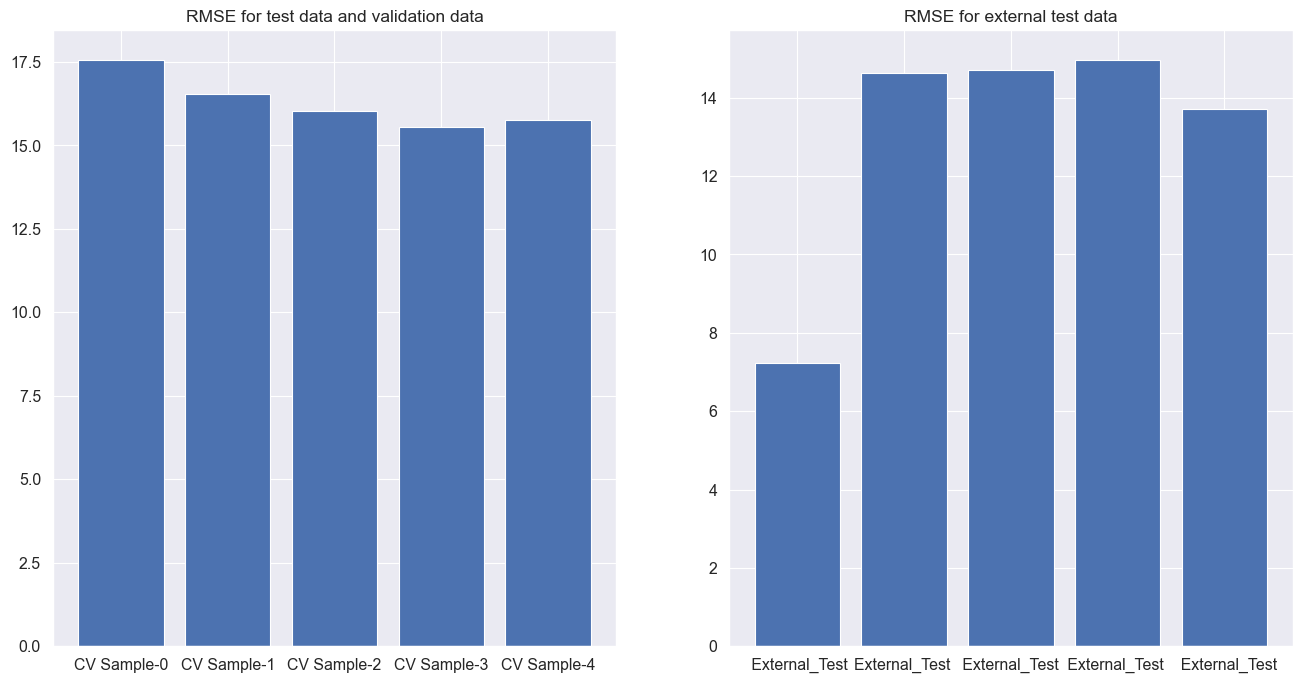

In [14]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_PredictRoomBooking_lightgbm,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


Average Test and Validation Cost: 14.98 Average External Test Cost: 13.7
Predict Room Booking dataset - Ant Colony Optimization


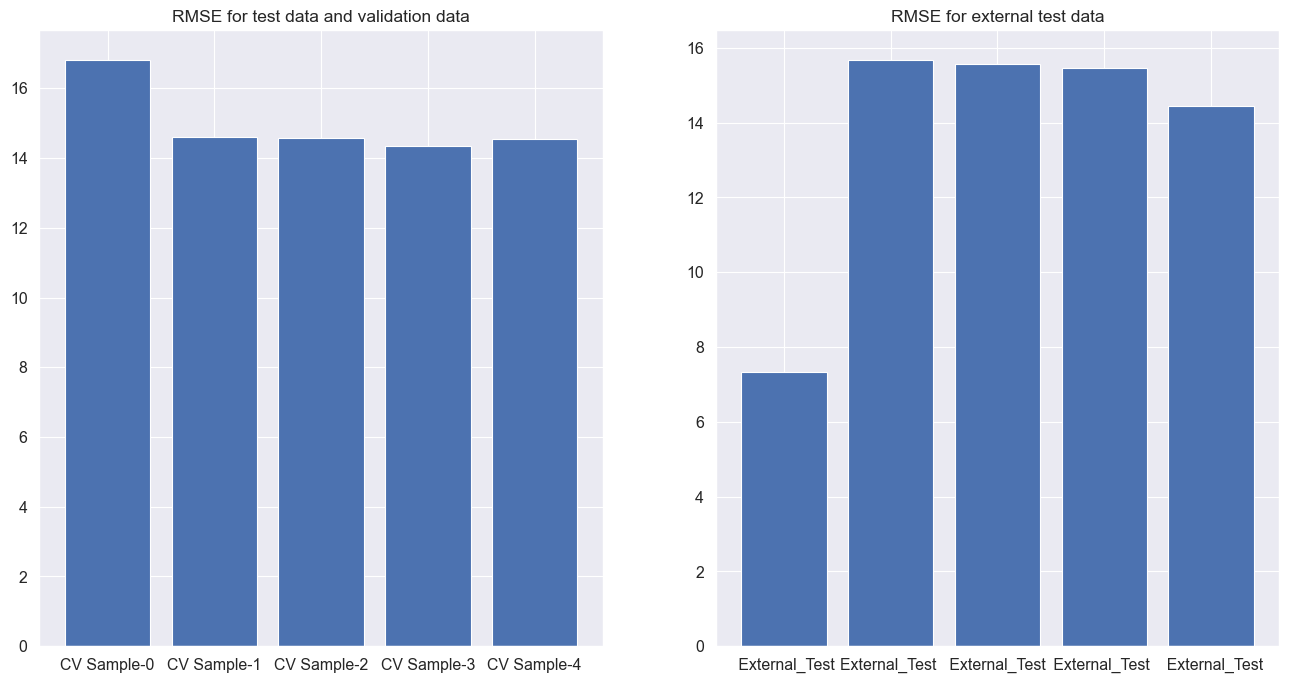

In [15]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1)#,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_PredictRoomBooking_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


Average Test and Validation Cost: 17.91 Average External Test Cost: 12.7
Predict Room Booking dataset - Simulated Annealing


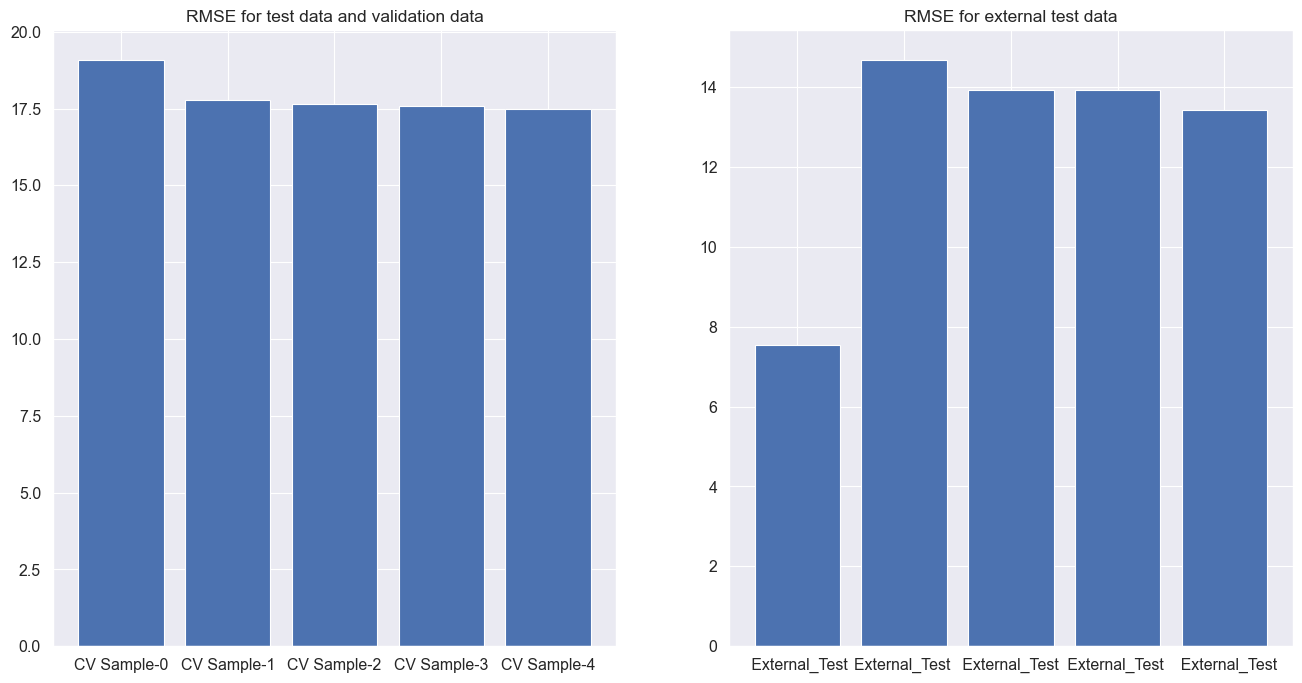

In [16]:
#model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1)
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_PredictRoomBooking_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


Average Test and Validation Cost: 11.17 Average External Test Cost: 11.19
Predict Room Booking dataset - Genetic Algorithm


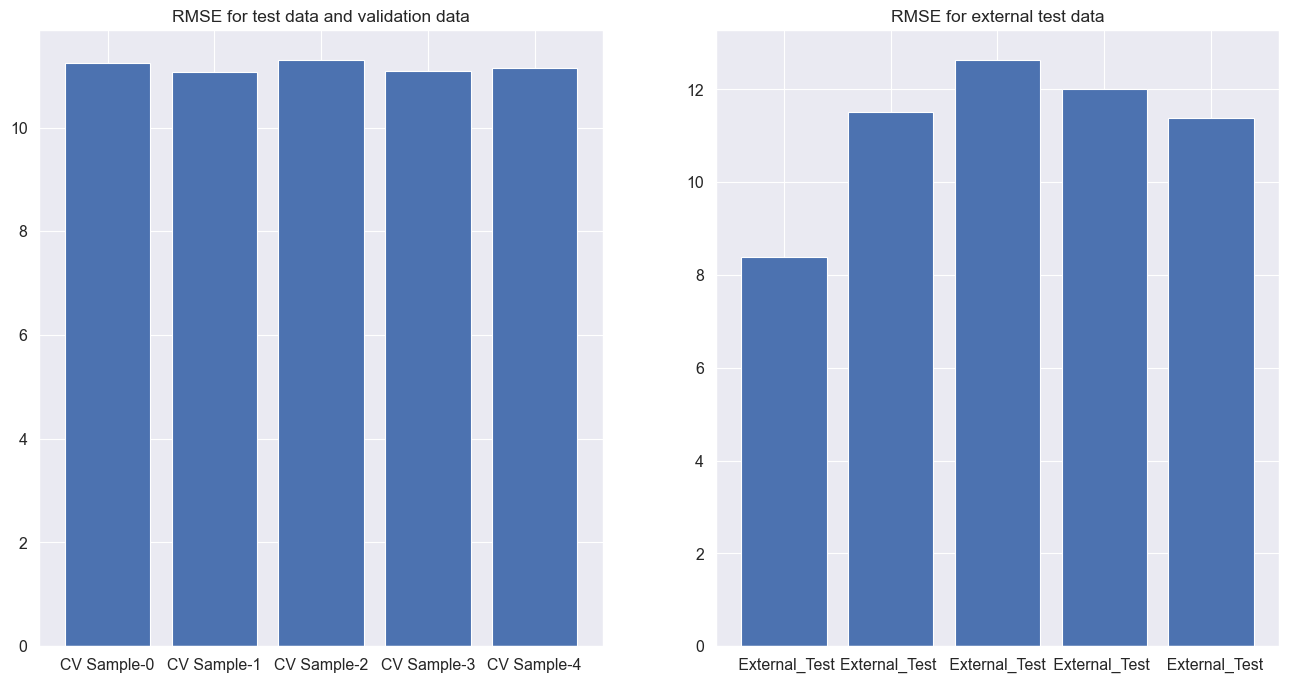

In [17]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_PredictRoomBooking_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


## Lightgbm 2nd Optimization - GA 1st Iteration Ouput as input feature list for 2nd iteration

In [52]:
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = best_columns_GA_PredictRoomBooking_lightgbm,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

In [56]:
#### Genetic Algorithm
best_columns_GA_PredictRoomBooking_lightgbm_v2 = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_PredictRoomBooking_lightgbm_v2.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_PredictRoomBooking_lightgbm_v2, output_file)



Best combined performance on test and validation data for generation 0 : 11.043706496988683
Best combined performance on test and validation data for generation 1 : 10.983557588466322
Best combined performance on test and validation data for generation 2 : 10.542139731532457
Best combined performance on test and validation data for generation 3 : 10.223690915657908
Best combined performance on test and validation data for generation 4 : 10.213804046452145
Best combined performance on test and validation data for generation 5 : 10.067656670614108
Best combined performance on test and validation data for generation 6 : 9.713605238532903
Best combined performance on test and validation data for generation 7 : 9.616279982219314
Best combined performance on test and validation data for generation 8 : 9.616279982219314
Best combined performance on test and validation data for generation 9 : 9.50068793688332
Best combined performance on test and validation data for generation 10 : 9.897968230

Average Test and Validation Cost: 9.51 Average External Test Cost: 9.63
Predict Room Booking dataset - Genetic Algorithm


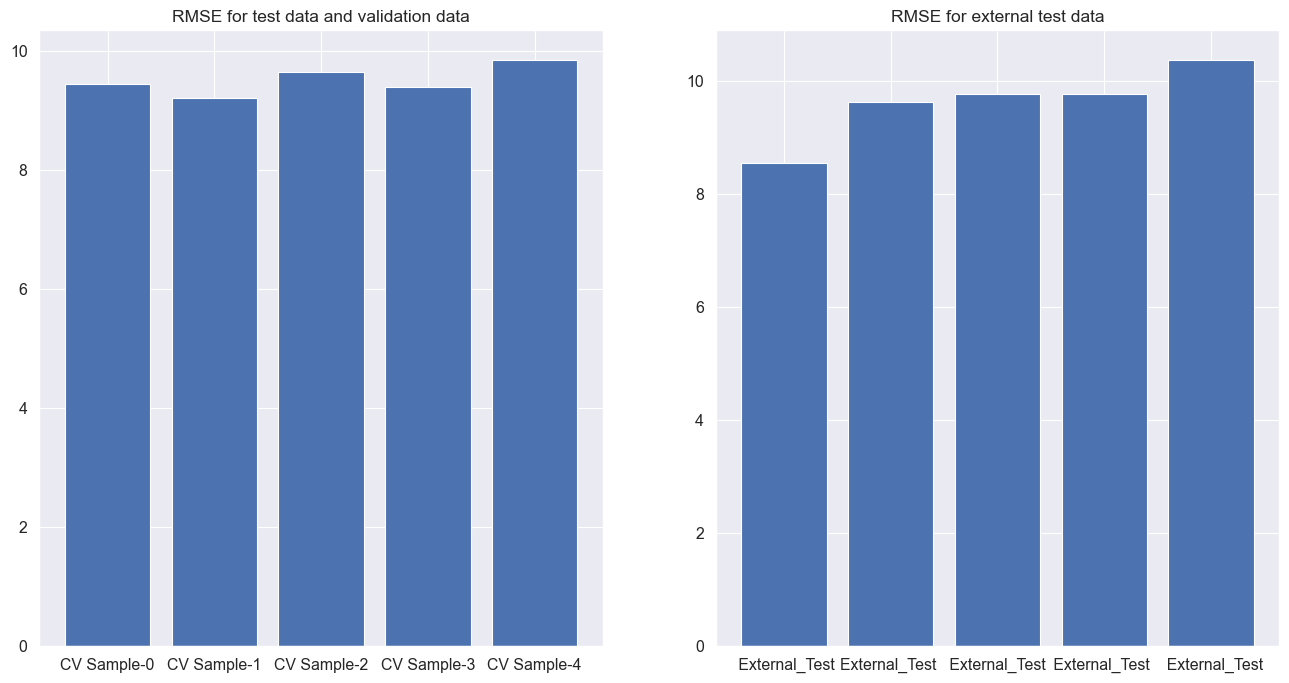

In [70]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_PredictRoomBooking_lightgbm_v2,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


## Lightgbm 3rd Optimization - GA 2nd Iteration Ouput as input feature list for 3rd iteration

In [72]:
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = best_columns_GA_PredictRoomBooking_lightgbm_v2,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

In [73]:
#### Genetic Algorithm
best_columns_GA_PredictRoomBooking_lightgbm_v3 = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_PredictRoomBooking_lightgbm_v3.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_PredictRoomBooking_lightgbm_v3, output_file)

Best combined performance on test and validation data for generation 0 : 9.364880809796805
Best combined performance on test and validation data for generation 1 : 9.118092608145279
Best combined performance on test and validation data for generation 2 : 8.919841833977179
Best combined performance on test and validation data for generation 3 : 8.919841833977179
Best combined performance on test and validation data for generation 4 : 8.919841833977179
Best combined performance on test and validation data for generation 5 : 8.881556855894916
Best combined performance on test and validation data for generation 6 : 8.678303846908179
Best combined performance on test and validation data for generation 7 : 8.678303846908179
Best combined performance on test and validation data for generation 8 : 8.678303846908179
Best combined performance on test and validation data for generation 9 : 8.678303846908179
Best combined performance on test and validation data for generation 10 : 8.67830384690817

Average Test and Validation Cost: 8.68 Average External Test Cost: 8.79
Predict Room Booking dataset - Genetic Algorithm


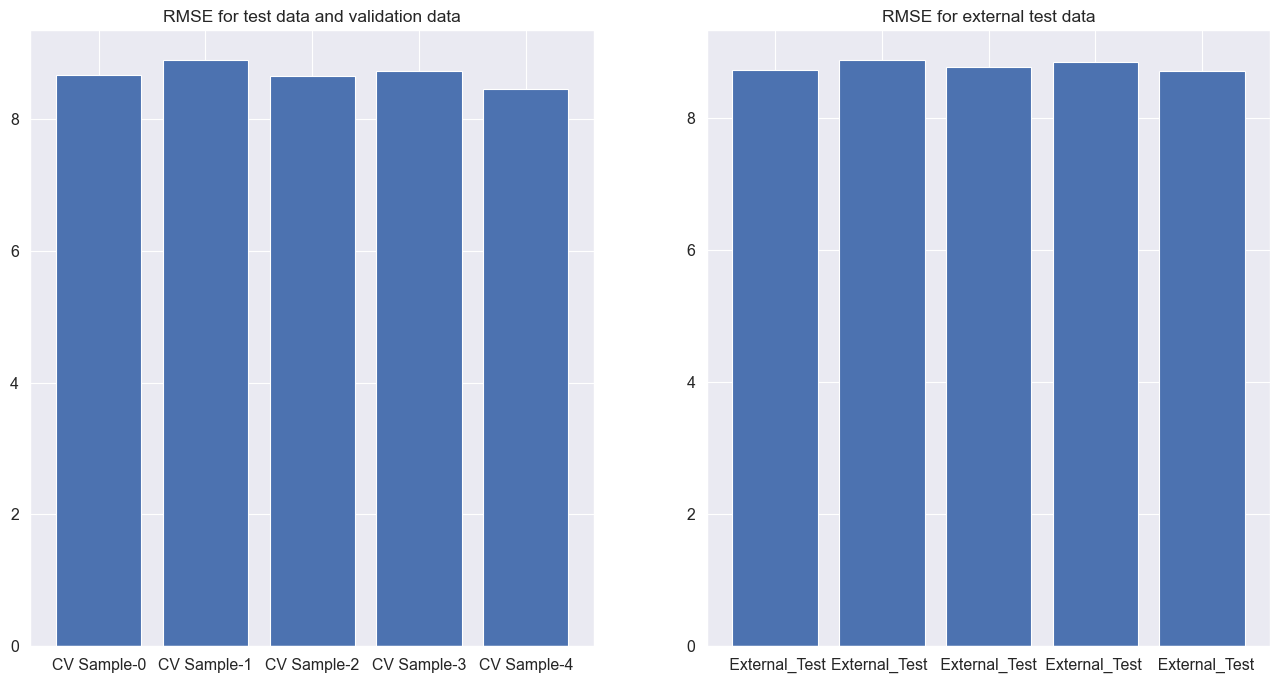

In [74]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_PredictRoomBooking_lightgbm_v3,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


## Lightgbm 4th Optimization - GA 3rd Iteration Ouput as input feature list for 4th iteration

In [76]:
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = best_columns_GA_PredictRoomBooking_lightgbm_v3,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

In [77]:
#### Genetic Algorithm
best_columns_GA_PredictRoomBooking_lightgbm_v4 = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_PredictRoomBooking_lightgbm_v4.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_PredictRoomBooking_lightgbm_v4, output_file)

Best combined performance on test and validation data for generation 0 : 9.596298187862573
Best combined performance on test and validation data for generation 1 : 8.646556323826047
Best combined performance on test and validation data for generation 2 : 8.628023485663864
Best combined performance on test and validation data for generation 3 : 8.628023485663864
Best combined performance on test and validation data for generation 4 : 8.628023485663864
Best combined performance on test and validation data for generation 5 : 8.628023485663864
Best combined performance on test and validation data for generation 6 : 8.628023485663864
Best combined performance on test and validation data for generation 7 : 8.628023485663864
Best combined performance on test and validation data for generation 8 : 8.628023485663864
Best combined performance on test and validation data for generation 9 : 8.628023485663864
Best combined performance on test and validation data for generation 10 : 8.62802348566386

Average Test and Validation Cost: 8.63 Average External Test Cost: 8.79
Predict Room Booking dataset - Genetic Algorithm


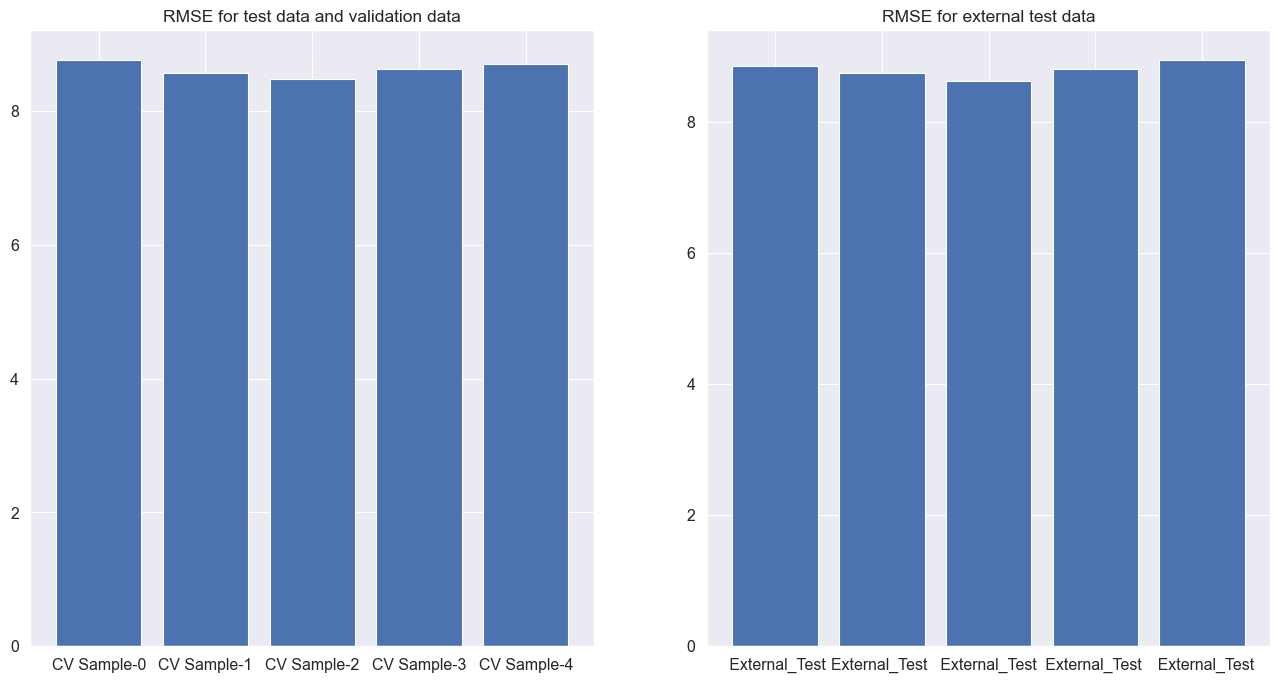

In [78]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_PredictRoomBooking_lightgbm_v4,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


## Lightgbm 5th Optimization - GA 4th Iteration Ouput as input feature list for 5th iteration

In [79]:
model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = best_columns_GA_PredictRoomBooking_lightgbm_v4,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'decrease',
                         average = None)

In [80]:
#### Genetic Algorithm
best_columns_GA_PredictRoomBooking_lightgbm_v5 = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_PredictRoomBooking_lightgbm_v5.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_PredictRoomBooking_lightgbm_v5, output_file)

Best combined performance on test and validation data for generation 0 : 10.235025921852868
Best combined performance on test and validation data for generation 1 : 10.235025921852868
Best combined performance on test and validation data for generation 2 : 9.596298187862573
Best combined performance on test and validation data for generation 3 : 8.818994062338936
Best combined performance on test and validation data for generation 4 : 8.628023485663864
Best combined performance on test and validation data for generation 5 : 8.628023485663864
Best combined performance on test and validation data for generation 6 : 8.628023485663864
Best combined performance on test and validation data for generation 7 : 8.628023485663864
Best combined performance on test and validation data for generation 8 : 8.628023485663864
Best combined performance on test and validation data for generation 9 : 8.628023485663864
Best combined performance on test and validation data for generation 10 : 8.628023485663

Average Test and Validation Cost: 8.63 Average External Test Cost: 8.79
Predict Room Booking dataset - Genetic Algorithm


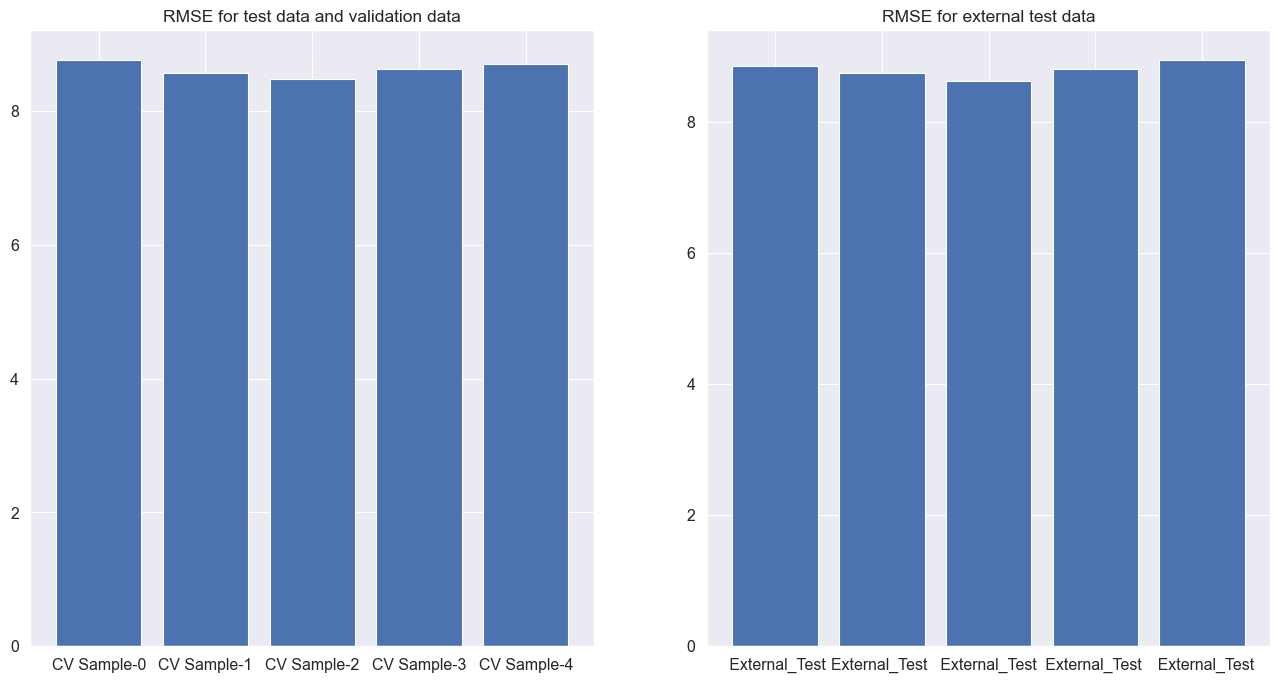

In [81]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'regression',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_PredictRoomBooking_lightgbm_v5,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'RMSE'
title = 'Predict Room Booking dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


In [87]:
print('Number of features at each iteration:',len(best_columns_GA_PredictRoomBooking_lightgbm),
      len(best_columns_GA_PredictRoomBooking_lightgbm_v2),
      len(best_columns_GA_PredictRoomBooking_lightgbm_v3),
      len(best_columns_GA_PredictRoomBooking_lightgbm_v4),
      len(best_columns_GA_PredictRoomBooking_lightgbm_v5))

Number of features at each iteration: 44 20 10 9 9


In [94]:
print('Final list of features:\n\n',best_columns_GA_PredictRoomBooking_lightgbm_v5)

Final list of features:

 ['AdjustedLeadTimeCumulativeNumberOfRoomsNet_Quartile_Encoded', 'AdjustedLeadTimeCumulativeRevenueNet_Quartile_Encoded', 'AdjustedLeadTimeCumulativeRevenueSubstract_Quartile_Encoded', 'CumulativeNumberOfRoomsNet_Quartile_Encoded', 'CumulativeNumberOfRoomsSubstract_Quartile_Encoded', 'CumulativeRevenueSubstract_Quartile_Encoded', 'DayOfMonth_Encoded', 'DayOfWeek_Encoded', 'MonthOfYear_Encoded']


## Predicted Vs Actual - External Test Data

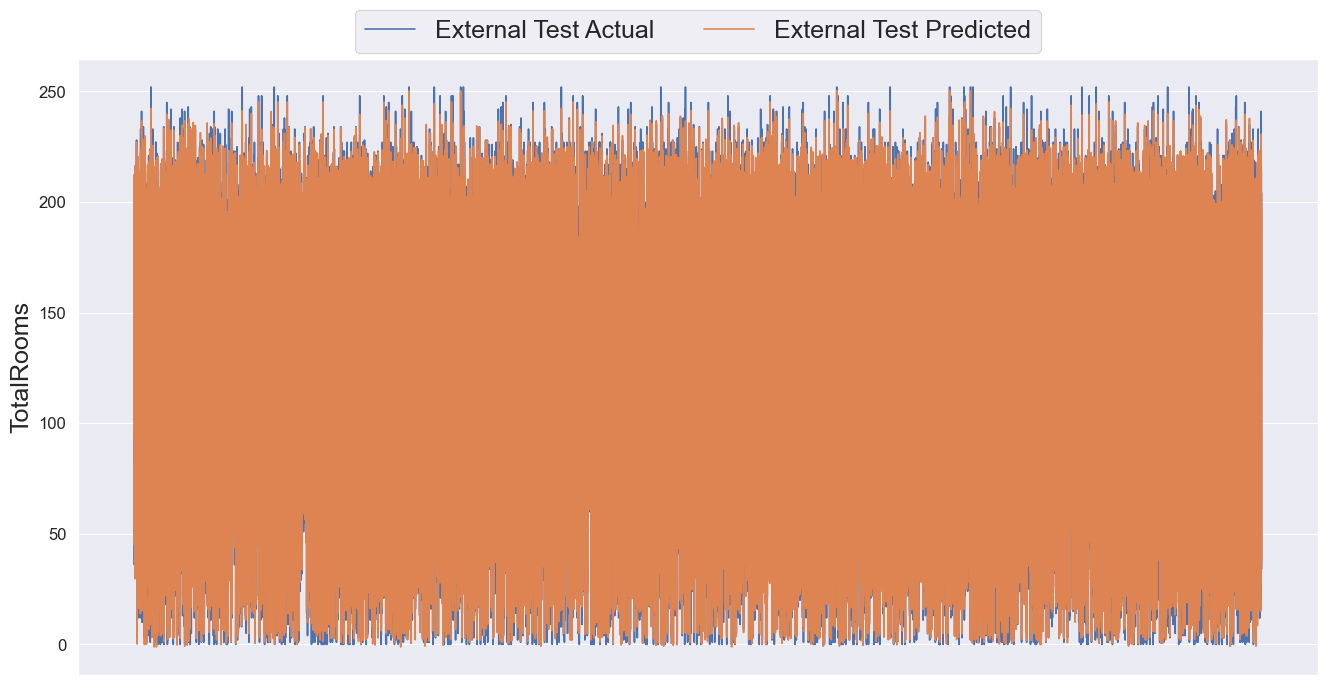

In [10]:
#train on training data
#predict on test data
result_df = get_metrics_df(model=model_use,
                           data_dict=data_dict,
                           dependent_variable=dependent_variable,
                           features=best_columns_GA_PredictRoomBooking_lightgbm_v5)

#plot actual vs predicted
result_df.plot()
plt.xticks([])
plt.yticks(fontsize=12)
plt.ylabel(dependent_variable[0], fontsize=18)
plt.legend(bbox_to_anchor=(0.5, 1.1),loc="upper center", fontsize=18,ncol=2)
# plt.title('Actual Vs. Predicted for external test data')